In [8]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from umap import UMAP
from scipy.stats import norm
import optuna
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from IPython.display import Image

optuna.logging.set_verbosity(optuna.logging.WARNING)
plt.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

In [10]:
train = pd.read_csv('/home/status3000/Downloads/train.csv')
test = pd.read_csv('/home/status3000/Downloads/test.csv') 
submission = pd.read_csv('/home/status3000/Downloads/sample_submission.csv')

In [11]:
data_train = pd.read_csv('/home/status3000/Downloads/train.csv')
train = pd.DataFrame(data_train)
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


# Load test dataframe

In [13]:
data_test = pd.read_csv('/home/status3000/Downloads/test.csv')
test = pd.DataFrame(data_test)
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [14]:
print("train shape:", train.shape)
print("test shape:", test.shape)

train shape: (1460, 81)
test shape: (1459, 80)


# Analyze target distribution

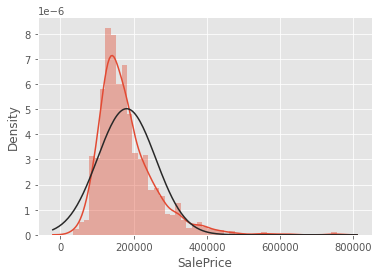

In [15]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.distplot(train.SalePrice, kde = True, hist=True, fit = norm)

# Logarithm the target to normalize it

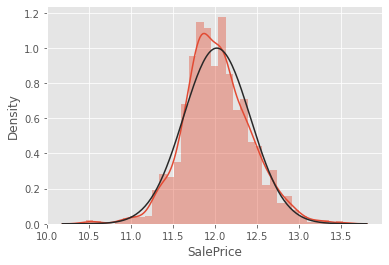

In [16]:
with warnings.catch_warnings():
    warnings.simplefilter('ignore')
    sns.distplot(np.log(train.SalePrice), kde = True, hist=True, fit = norm);

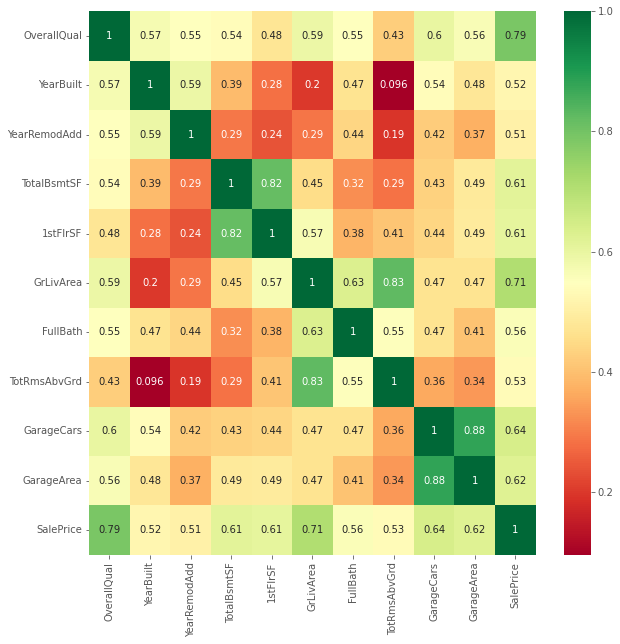

In [17]:
corrmat = train.corr()
top_corr_features = corrmat.index[abs(corrmat["SalePrice"])>0.5]
plt.figure(figsize=(10, 10))
g = sns.heatmap(train[top_corr_features].corr(),annot=True,cmap="RdYlGn")

# Remove useless features

In [18]:
train.drop(['Id'],axis =1,inplace=True)
test.drop(['Id'],axis =1,inplace=True)

# Split numeric and string features

In [19]:
num_train = train.select_dtypes(exclude=[object])
num_test = test.select_dtypes(exclude=[object])
str_train = train.select_dtypes(include=[object])
str_test = test.select_dtypes(include=[object])

# Add derived features

In [ ]:
# Add ages
num_train['HouseAge'] = 2021 - num_train.YearBuilt
num_train['RemodAge'] = 2021 - num_train.YearRemodAdd
num_train['SoldAge'] = 2021 - num_train.YrSold
num_test['HouseAge'] = 2021 - num_test.YearBuilt
num_test['RemodAge'] = 2021 - num_test.YearRemodAdd
num_test['SoldAge'] = 2021 - num_test.YrSold
# Add sum of all areas
num_train['HouseSum'] = num_train[['MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF',
                           '2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
                            'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']].sum(axis=1)
num_test['HouseSum'] = num_test[['MasVnrArea','BsmtFinSF1','BsmtFinSF2','TotalBsmtSF','1stFlrSF',
                           '2ndFlrSF','GrLivArea','GarageArea','WoodDeckSF','OpenPorchSF',
                            'EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea']].sum(axis=1)

# Fill missed values

In [21]:
def fillna(df):
    for i in df.columns:
        if df[i].dtype == 'O': df[i] = df[i].fillna('missed')
        else: df[i] = df[i].fillna(0)
    return df



In [ ]:
num_train = fillna(num_train)
num_test = fillna(num_test)

# Pretrain to fill missed target values

In [23]:
x_pre, y_pre = num_train.drop('SalePrice', axis=1).to_numpy(), num_train['SalePrice'].to_numpy()
y_pre = np.log(y_pre)
x_test_pre = num_test.to_numpy()

In [25]:
%%time
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3000,
                       max_depth=3,
                       gamma=0,
                       colsample_bytree=0.7,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       objective='reg:squarederror')
pre = xgboost.fit(x_pre,y_pre)
print('R2',r2_score(y_pre,xgboost.predict(x_pre)))

R2 0.9710032877698179
CPU times: user 44.3 s, sys: 319 ms, total: 44.6 s
Wall time: 15.1 s


In [ ]:
num_test['SalePrice'] = np.exp(xgboost.predict(x_test_pre))

# Clasterize number features

# Split full dataframe to numeric and string

In [27]:
train = pd.concat([num_train, str_train], axis=1, sort=True).reset_index(drop=True)
test = pd.concat([num_test, str_test], axis=1, sort=True).reset_index(drop=True)
full = pd.concat([train, test], sort=True).reset_index(drop=True)

In [ ]:
str = full.select_dtypes(include=[object])
num = full.select_dtypes(exclude=[object])
# Fill none number elements
num = fillna(num)

# Use embedding models

In [ ]:
# Set 3 dimensions to get on the output
pca = PCA(n_components=3) 
tsne = TSNE(n_components=3, perplexity=50)
umap = UMAP(n_components=3, n_neighbors=5)
# Normilize
X = StandardScaler().fit_transform(num.drop('SalePrice', axis=1))
# Train
X_pca = pca.fit_transform(X)
X_tsne = tsne.fit_transform(X)
X_umap = umap.fit_transform(X)

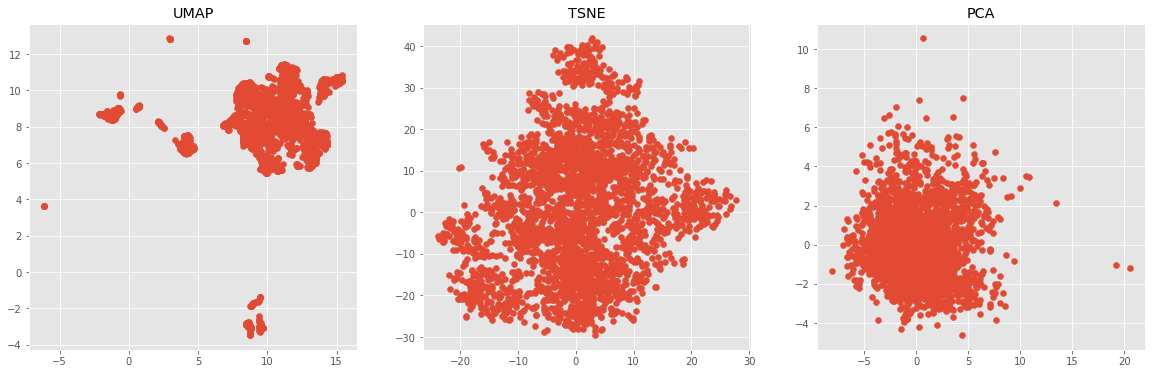

In [30]:
# Draw
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1.scatter(X_umap[:, 0], X_umap[:, 1])
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1])
ax3.scatter(X_pca[:, 0], X_pca[:, 1])
ax1.set_title('UMAP')
ax2.set_title('TSNE')
ax3.set_title('PCA');

CPU times: user 895 ms, sys: 159 ms, total: 1.05 s
Wall time: 893 ms


Text(0.5, 0.92, 'PCA')

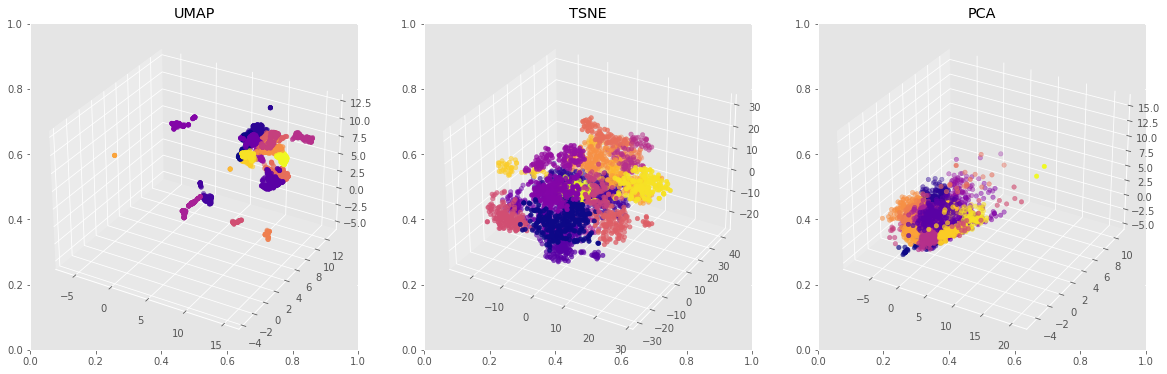

In [31]:
%%time
ag = AgglomerativeClustering(20)
ag_umap = ag.fit_predict(X_umap)
ag_tsne = ag.fit_predict(X_tsne)
ag_pca = ag.fit_predict(X_pca)
# Draw
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 6))
ax1 = fig.add_subplot(1,3,1, projection='3d')
ax2 = fig.add_subplot(1,3,2, projection='3d')
ax3 = fig.add_subplot(1,3,3, projection='3d')
ax1.scatter(X_umap[:, 0], X_umap[:, 1], X_umap[:, 2], c = ag_umap, cmap='plasma')
ax2.scatter(X_tsne[:, 0], X_tsne[:, 1], X_tsne[:, 2], c = ag_tsne, cmap='plasma')
ax3.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c = ag_pca, cmap='plasma')
ax1.set_title('UMAP')
ax2.set_title('TSNE')
ax3.set_title('PCA');

# Add new (cluster) feature to numeric dataframe

In [ ]:
num['Cluster'] = ag_pca
num = pd.concat([num, pd.get_dummies(num['Cluster'], prefix=('Cluster'))], axis=1)
num.drop('Cluster', axis=1, inplace=True)

# Analyze house quality features

In [ ]:
# Move quality features from string to numeric features
qual_words = ['Qual', 'Class','QC']
qual_features = [i for i in str.columns if any(x in i for x in qual_words)]
str.drop(qual_features, axis = 1, inplace=True)
num = num.join(full[qual_features])
# Turn string values to numeric
num.replace(['Ex','Gd', 'TA', 'Fa', 'Po'], [5,4,3,2,1], inplace=True)

# Label encoding on full dataframe

In [34]:
full = pd.concat([str, num], axis=1, sort=True).reset_index(drop=True)
# OneHotEncoding
for i in full.columns:
    if full[i].dtype == 'O' and i != 'SalePrice':
        full = pd.concat([full, pd.get_dummies(full[i], prefix=(i+'M'))], axis=1)
        full.drop(i, axis=1, inplace=True)
# Fill none values
full = fillna(full)

# Prepare data to train

# Split to train and test dataframes

In [35]:
train, test = full.loc[:1459], full.loc[1460:].drop(['SalePrice'], axis=1)

In [36]:
X, Y = train[test.columns.to_list()].to_numpy(), train['SalePrice'].to_numpy()
Y = np.log(Y)
X_test = test.to_numpy()
Y_test = full.loc[1460:]['SalePrice'].to_numpy()

# Fit models

In [37]:
%%time
# Set param's range
lr_from = 0.001
lr_to = 0.1
fr_from = 0.1
fr_to = 1
dec_from = 1
dec_to = 10
nl_from = 4
nl_to = 20

# 1. Define an objective function to be maximized.
def objective(trial):
    # 2. Suggest values for the hyperparameters using a trial object.
    learning_rate = trial.suggest_float('learning_rate', lr_from, lr_to, log=True)
    bagging_fraction = trial.suggest_float('bagging_fraction', fr_from, fr_to, log=True)
    feature_fraction = trial.suggest_float('feature_fraction', fr_from, fr_to, log=True)
    num_leaves = trial.suggest_int('num_leaves', nl_from, nl_to, log=True)
    bagging_freq = trial.suggest_int('bagging_freq', dec_from, dec_to, log=True)
    bagging_seed = trial.suggest_int('bagging_seed', dec_from, dec_to, log=True)
    feature_fraction_seed = trial.suggest_int('feature_fraction_seed', dec_from, dec_to, log=True)
    # Models
    regr_obj = LGBMRegressor(objective='regression',num_leaves=num_leaves, learning_rate=learning_rate, 
                         n_estimators=5000,max_bin=200, bagging_fraction=bagging_fraction,
                         bagging_freq=bagging_freq, bagging_seed=bagging_seed,feature_fraction=feature_fraction,
                         feature_fraction_seed=feature_fraction_seed, verbose=-1)
    # Fit    
    regr_obj_data = regr_obj.fit(X,Y)
    pred = regr_obj_data.predict(X_test)
    error = r2_score(Y_test, pred)
    return error

# 3. Create a study object and optimize the objective function.
optune = optuna.create_study(direction='minimize')
optune.optimize(objective, n_trials=500, show_progress_bar=True)
optune.best_params

/home/status3000/anaconda3/envs/tensorflow/lib/python3.7/site-packages/optuna/progress_bar.py:47: ExperimentalWarning: Progress bar is experimental (supported from v1.2.0). The interface can change in the future.
  self._init_valid()


  0%|          | 0/500 [00:00<?, ?it/s]

[LightGBM] [Warning] feature_fraction is set=0.7781747603249493, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7781747603249493
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.10461126657383663, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10461126657383663
[LightGBM] [Warning] feature_fraction is set=0.3994246379764703, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3994246379764703
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7553200975731972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7553200975731972
[LightGBM] [Warning] feature_fraction is set=0.31124165577141527, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.31124165577141527
[LightGBM] [Warning] bag

[LightGBM] [Warning] feature_fraction is set=0.29751625262389403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.29751625262389403
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.29261473352373124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.29261473352373124
[LightGBM] [Warning] feature_fraction is set=0.2047004172024545, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2047004172024545
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.2023475565470337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2023475565470337
[LightGBM] [Warning] feature_fraction is set=0.21450012902429824, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.21450012902429824
[LightGBM] [Warning] b

[LightGBM] [Warning] feature_fraction is set=0.15407970359468856, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15407970359468856
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.15385092492579672, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15385092492579672
[LightGBM] [Warning] feature_fraction is set=0.14465219196239773, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14465219196239773
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.15611321399357309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.15611321399357309
[LightGBM] [Warning] feature_fraction is set=0.1493794819989482, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1493794819989482
[LightGBM] [Warning]

[LightGBM] [Warning] feature_fraction is set=0.1655301257564806, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1655301257564806
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.17281369824865192, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17281369824865192
[LightGBM] [Warning] feature_fraction is set=0.11906866094170906, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11906866094170906
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.10720155553919151, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10720155553919151
[LightGBM] [Warning] feature_fraction is set=0.12869552197057915, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12869552197057915
[LightGBM] [Warning]

[LightGBM] [Warning] feature_fraction is set=0.14306854994883003, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.14306854994883003
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.8949301662025216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8949301662025216
[LightGBM] [Warning] feature_fraction is set=0.12573980046104827, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12573980046104827
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1015734326223305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1015734326223305
[LightGBM] [Warning] feature_fraction is set=0.10542178415166291, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10542178415166291
[LightGBM] [Warning] b

[LightGBM] [Warning] feature_fraction is set=0.1432834473313064, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1432834473313064
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.11884084696170527, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11884084696170527
[LightGBM] [Warning] feature_fraction is set=0.11984148917129496, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11984148917129496
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] bagging_fraction is set=0.10653104521108424, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10653104521108424
[LightGBM] [Warning] feature_fraction is set=0.10484930301576224, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10484930301576224
[LightGBM] [Warnin

[LightGBM] [Warning] feature_fraction is set=0.11791403308254099, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11791403308254099
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.12086978807048468, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12086978807048468
[LightGBM] [Warning] feature_fraction is set=0.11284420983198332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11284420983198332
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.11455472650456654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11455472650456654
[LightGBM] [Warning] feature_fraction is set=0.10791795793311484, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10791795793311484
[LightGBM] [Warnin

[LightGBM] [Warning] feature_fraction is set=0.12035549744506259, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12035549744506259
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.10009361517554877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10009361517554877
[LightGBM] [Warning] feature_fraction is set=0.12338656845909661, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12338656845909661
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.10498583495430554, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10498583495430554
[LightGBM] [Warning] feature_fraction is set=0.13384517580998664, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13384517580998664
[LightGBM] [Warnin

[LightGBM] [Warning] feature_fraction is set=0.10519350690536872, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10519350690536872
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.1255668655879541, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1255668655879541
[LightGBM] [Warning] feature_fraction is set=0.1227938922932538, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1227938922932538
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.10452710446500071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10452710446500071
[LightGBM] [Warning] feature_fraction is set=0.10032297134409793, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10032297134409793
[LightGBM] [Warning] b

[LightGBM] [Warning] feature_fraction is set=0.11355815705865943, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11355815705865943
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.2725813574393899, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2725813574393899
[LightGBM] [Warning] feature_fraction is set=0.11827659860850398, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11827659860850398
[LightGBM] [Warning] bagging_freq is set=9, subsample_freq=0 will be ignored. Current value: bagging_freq=9
[LightGBM] [Warning] bagging_fraction is set=0.10689578204485893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10689578204485893
[LightGBM] [Warning] feature_fraction is set=0.12590258941047214, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12590258941047214
[LightGBM] [Warning]

[LightGBM] [Warning] feature_fraction is set=0.11817619951682069, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11817619951682069
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.1191140422548685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1191140422548685
[LightGBM] [Warning] feature_fraction is set=0.12015704883315742, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12015704883315742
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Warning] bagging_fraction is set=0.10577485129754322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10577485129754322
[LightGBM] [Warning] feature_fraction is set=0.1283743113730982, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1283743113730982
[LightGBM] [Warning] b

[LightGBM] [Warning] feature_fraction is set=0.10123992305058954, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10123992305058954
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.11830251237731189, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11830251237731189
[LightGBM] [Warning] feature_fraction is set=0.10730113131316411, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10730113131316411
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.10845116658001004, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10845116658001004
[LightGBM] [Warning] feature_fraction is set=0.10678509863167285, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10678509863167285
[LightGBM] [Warnin

[LightGBM] [Warning] feature_fraction is set=0.10318405204847109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10318405204847109
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.10382039648898847, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10382039648898847
[LightGBM] [Warning] feature_fraction is set=0.10348980294904522, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10348980294904522
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.10354480515450788, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10354480515450788
[LightGBM] [Warning] feature_fraction is set=0.10109900932944567, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10109900932944567
[LightGBM] [Warnin

[LightGBM] [Warning] feature_fraction is set=0.11247132185351807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11247132185351807
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.10387715986691679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10387715986691679
[LightGBM] [Warning] feature_fraction is set=0.10543489227521868, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10543489227521868
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.10022307168454916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10022307168454916
[LightGBM] [Warning] feature_fraction is set=0.11129931521172277, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11129931521172277
[LightGBM] [Warnin

[LightGBM] [Warning] feature_fraction is set=0.10450430507093846, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10450430507093846
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.11054594960587062, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11054594960587062
[LightGBM] [Warning] feature_fraction is set=0.10365920785001681, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10365920785001681
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1159051695256325, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1159051695256325
[LightGBM] [Warning] feature_fraction is set=0.10468661037264859, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10468661037264859
[LightGBM] [Warning]

[LightGBM] [Warning] feature_fraction is set=0.11228960729880619, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11228960729880619
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.11252782058279187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11252782058279187
[LightGBM] [Warning] feature_fraction is set=0.10674803857309753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10674803857309753
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.13037483907906083, subsample=1.0 will be ignored. Current value: bagging_fraction=0.13037483907906083
[LightGBM] [Warning] feature_fraction is set=0.11607745133669, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11607745133669
[LightGBM] [Warning] bag

[LightGBM] [Warning] feature_fraction is set=0.1039025857714686, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1039025857714686
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1134924961721643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1134924961721643
[LightGBM] [Warning] feature_fraction is set=0.10019549897555005, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10019549897555005
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.10020540741558542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10020540741558542
[LightGBM] [Warning] feature_fraction is set=0.10025770188451379, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10025770188451379
[LightGBM] [Warning] b

[LightGBM] [Warning] feature_fraction is set=0.10865377684406351, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10865377684406351
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.10007656032134406, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10007656032134406
[LightGBM] [Warning] feature_fraction is set=0.1000230835973798, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1000230835973798
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.11178030139880679, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11178030139880679
[LightGBM] [Warning] feature_fraction is set=0.10515682920228415, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10515682920228415
[LightGBM] [Warning]

[LightGBM] [Warning] feature_fraction is set=0.10481656838885135, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10481656838885135
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.10553059359797143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10553059359797143
[LightGBM] [Warning] feature_fraction is set=0.10003597769060814, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10003597769060814
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.11621309492773413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11621309492773413
[LightGBM] [Warning] feature_fraction is set=0.1111784647403104, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1111784647403104
[LightGBM] [Warning]

[LightGBM] [Warning] feature_fraction is set=0.10546028909411297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10546028909411297
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.11164213919916643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11164213919916643
[LightGBM] [Warning] feature_fraction is set=0.11458969162225109, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11458969162225109
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.10539954425801232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10539954425801232
[LightGBM] [Warning] feature_fraction is set=0.13353605234774932, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13353605234774932
[LightGBM] [Warnin

[LightGBM] [Warning] feature_fraction is set=0.10405448994313808, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10405448994313808
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1151597002529275, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1151597002529275
[LightGBM] [Warning] feature_fraction is set=0.11259962172070413, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11259962172070413
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.1336717393846916, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1336717393846916
[LightGBM] [Warning] feature_fraction is set=0.12242865049241274, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.12242865049241274
[LightGBM] [Warning] b

[LightGBM] [Warning] feature_fraction is set=0.10456076410713445, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10456076410713445
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Warning] bagging_fraction is set=0.11188942101707842, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11188942101707842
[LightGBM] [Warning] feature_fraction is set=0.10028827473293009, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10028827473293009
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] bagging_fraction is set=0.12101213450353791, subsample=1.0 will be ignored. Current value: bagging_fraction=0.12101213450353791
[LightGBM] [Warning] feature_fraction is set=0.10988994947236558, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10988994947236558
[LightGBM] [Warnin

[LightGBM] [Warning] feature_fraction is set=0.10010620693386722, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10010620693386722
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.1051786239844732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1051786239844732
[LightGBM] [Warning] feature_fraction is set=0.1034581786142074, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.1034581786142074
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.10443339590202552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10443339590202552
[LightGBM] [Warning] feature_fraction is set=0.10410838257712278, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10410838257712278
[LightGBM] [Warning] b

[LightGBM] [Warning] feature_fraction is set=0.10347518967360715, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10347518967360715
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.1002667994608927, subsample=1.0 will be ignored. Current value: bagging_fraction=0.1002667994608927
[LightGBM] [Warning] feature_fraction is set=0.10443744730202838, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10443744730202838
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.10070384459397459, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10070384459397459
[LightGBM] [Warning] feature_fraction is set=0.10845490276311072, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10845490276311072
[LightGBM] [Warning]

[LightGBM] [Warning] feature_fraction is set=0.10019969619630871, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10019969619630871
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Warning] bagging_fraction is set=0.10726469705859921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10726469705859921
[LightGBM] [Warning] feature_fraction is set=0.11658419467078365, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.11658419467078365
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] bagging_fraction is set=0.10012819268311851, subsample=1.0 will be ignored. Current value: bagging_fraction=0.10012819268311851
[LightGBM] [Warning] feature_fraction is set=0.10817371549373332, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10817371549373332
[LightGBM] [Warnin

CPU times: user 1h 7min 46s, sys: 59.9 s, total: 1h 8min 46s
Wall time: 19min 38s


{'learning_rate': 0.0010008281177337564,
 'bagging_fraction': 0.10010917666647698,
 'feature_fraction': 0.1039276406467678,
 'num_leaves': 7,
 'bagging_freq': 7,
 'bagging_seed': 9,
 'feature_fraction_seed': 8}

# RandomForestRegressor

In [38]:
GBR = GradientBoostingRegressor(n_estimators=3000, 
                            learning_rate=0.05, 
                            max_depth=4, 
                            max_features='sqrt', 
                            min_samples_leaf=15, 
                            min_samples_split=10, 
                            loss='huber', 
                            random_state =42)  
GBR.fit(X,Y)
print('R2',r2_score(Y,GBR.predict(X)))
GBR_result = np.exp(GBR.predict(X_test))

R2 0.9794828163025464


# XGBRegressor

In [39]:
xgboost = XGBRegressor(learning_rate=0.01,
                       n_estimators=3000,
                       max_depth=3,
                       gamma=0,
                       colsample_bytree=0.7,
                       scale_pos_weight=1,
                       reg_alpha=0.00006,
                       objective='reg:squarederror')
xgboost.fit(X,Y)
print('R2',r2_score(Y,xgboost.predict(X)))
xgboost_result = np.exp(xgboost.predict(X_test))

R2 0.9786299273961355


# LGBMRegressor

In [40]:
lgbm = LGBMRegressor(objective='regression',num_leaves=4, learning_rate=0.01, 
                         n_estimators=5000,max_bin=200, bagging_fraction=0.75,
                         bagging_freq=5, bagging_seed=7,feature_fraction=0.2,
                         feature_fraction_seed=7, verbose=-1)
lgbm.fit(X,Y)
print('R2',r2_score(Y,lgbm.predict(X)))
lgbm_result = np.exp(lgbm.predict(X_test))

[LightGBM] [Warning] feature_fraction is set=0.2, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] bagging_fraction is set=0.75, subsample=1.0 will be ignored. Current value: bagging_fraction=0.75
R2 0.9607362566613361


# CatBoostRegressor

In [41]:
cat = CatBoostRegressor(iterations = 10000, learning_rate = .08, eval_metric = 'RMSE',
                        random_seed = 42, logging_level=  'Silent', loss_function = 'RMSE',
                        od_type = 'Iter', od_wait = 1000, one_hot_max_size = 20,
                        l2_leaf_reg = 100, depth = 3, rsm = .6,
                        random_strength = 2, bagging_temperature = 10)
cat.fit(X,Y)
print('R2',r2_score(Y,cat.predict(X)))
cat_result = np.exp(cat.predict(X_test))

R2 0.984367759615612


In [42]:
# Save to the file
to_save = pd.DataFrame(lgbm_result.tolist(), columns=['SalePrice'], index=range(1461, 2920)).rename_axis('Id')
to_save.to_csv('submission.csv')

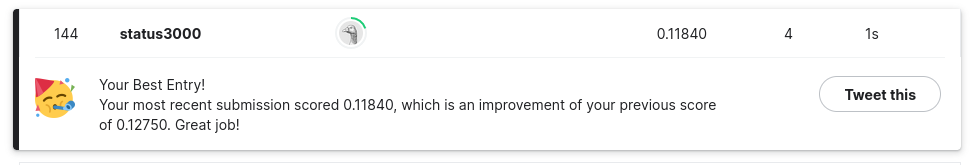

In [43]:
Image("/home/status3000/Desktop/kagge_housing_submit.png")

In [54]:
!pip install mlxtend

     |████████████████████████████████| 1.3 MB 1.3 MB/s eta 0:00:01


In [55]:
from mlxtend.regressor import StackingCVRegressor

In [56]:
stack_gen = StackingCVRegressor(regressors=(GBR, xgboost, lgbm, cat),
                                meta_regressor=cat,
                                use_features_in_secondary=True)

In [63]:
def blended_predictions(X):
    return ((0.15 * lgbm.predict(X)) + \
            (0.15 * xgboost.predict(X)) + \
            (0.3 * GBR.predict(X)) + \
            (0.3 * cat.predict(X)) + \
            (0.1 * stack_gen.predict(np.array(X))))

def rmse(y, y_pred):
    return np.sqrt(mean_squared_error(y, y_pred))

In [64]:
blended_score = rmse(Y, blended_predictions(X))
print('Blended Prediction RMSE: {}'.format(blended_score))

NotFittedError: This StackingCVRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this method.